## Pre-training and fine-tuning BERT from Scratch
### Autor: Antonio Castañares Rodríguez, A20599898
### CS 577: Deep Learning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub as kh
import matplotlib.pyplot as plt
import random
import os
import re
import warnings

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
def read_file(file_path):
    """
        Read the file and return the text.
    """
    with open(file_path, 'r', encoding='UTF-8') as f:
      text=[]
      for line in f:
        text.append(line.replace('\n',''))
    return text

def evaluate_model(model, dataloader):
    """
        Evaluate the model and return metrics AND the raw predictions/labels
        for confusion matrix plotting.
    """
    model.eval()

    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted_class = torch.max(outputs, dim=1)

            all_predictions.extend(predicted_class.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    precision = precision_score(all_true_labels, all_predictions, average='binary')
    recall = recall_score(all_true_labels, all_predictions, average='binary')
    f1 = f1_score(all_true_labels, all_predictions, average='binary')

    # Return everything in a dictionary
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "true_labels": all_true_labels,
        "predictions": all_predictions
    }

def plot_confusion_matrix(true_labels, predictions):
    """
    Generates and plots a confusion matrix.
    """
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Define the labels for the axes
    class_names = ['Negative', 'Positive']

    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    # Add titles and labels
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Show the plot
    plt.show()

### Pre-training BERT

Pre-training is the foundational **process of training a model on a massive, unlabeled dataset.** The objective is not to solve a specific task, but for the model to develop a deep, **generalized understanding of the language** itself by learning the intricate patterns of grammar, context, and the semantic relationships between words.

BERT was the **first deeply bidirectional model,** meaning that previous models could only be trained to process text from left-to-right or right-to-left. It introduced two novel pre-training objectives to achieve this bidirectionality:

- **Masked Language Model (MLM):** In this task, **15% of all input tokens** in each sequence were randomly selected for prediction. However, since the [MASK] token does not exist during fine-tuning, this would create a mismatch. To mitigate this, the selected tokens were handled with the following strategy:

  - **80% of the time,** the token was replaced with the [MASK] token.

  - **10% of the time,** the token was replaced with a random word from the vocabulary.

  - **10% of the time,** the token was left unchanged.

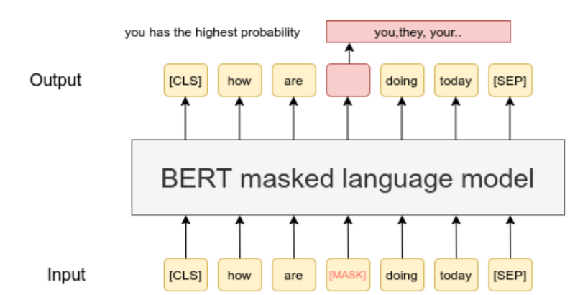

- **Next Sentence Prediction (NSP):** The model was given two sentences, A and B. For each pre-training example, **50% of the time B** was the actual sentence that followed A, and **50% of the time it was a random sentence** from the corpus. This taught the model to understand the relationships between sentences.

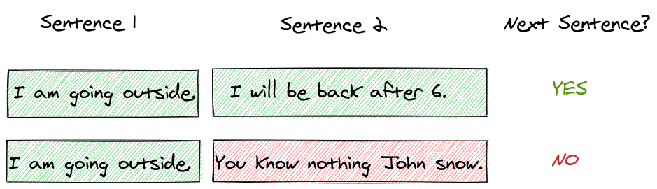

Futhermore, BERT differentiates the sentences in two ways: using the special token **[SEP]** and **position embeddings** associate to each token.

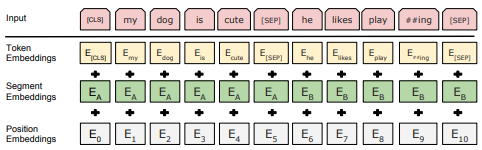

Finally, let's implement the pre-training for BERT.

In [3]:
class BertCorpusDataset(Dataset):
    """
        This class recieves the dataset and prepare it for MLM and NSP
    """
    def __init__(self, texts, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.texts = self._apply_nsp(texts)

    def _apply_nsp(self, texts):
        """
            Prepares the dataset for NSP, where we have pairs of sentences (A and B)
            There is 50% of posibilities to select B randomly
            There is 50% of posibilities to select B as the correct next sentence
        """
        sentence_pairs = []
        for i in range(len(texts)-1):
            # For each sentence, 50% chance of getting actual next sentence vs random sentence
            if random.random() < 0.5:
                # The next sentence is the actual next sentence
                next_sent_idx = i + 1
                is_next = 1
            else:
                # The next sentence is a random sentence for the corpus
                next_sent_idx = random.randint(0, len(texts)-1)
                is_next = 0

            # Store the pairs
            sentence_pairs.append({
                'sent1': texts[i],
                'sent2': texts[next_sent_idx],
                'is_next': is_next
            })
        return sentence_pairs

    def _apply_mlm(self, tokens):
        """
            Prepares the dataset for MLM, where we mask some tokens and predict them
        """
        mlm_positions = []
        mlm_labels = []
        n_tokens = len(tokens)

        # Select 15% of tokens randomly for MLM
        n_mask = max(1, int(0.15 * n_tokens))
        mask_candidates = list(range(n_tokens))             # Get a list from 0 to n_tokens
        random.shuffle(mask_candidates)                     # Rearranges them into a random order.
        mask_positions = sorted(mask_candidates[:n_mask])   # Order the list

        for pos in mask_positions:
            # For each position, we store the index and the token
            mlm_positions.append(pos)
            mlm_labels.append(tokens[pos])

            # However, since the [MASK] token does not exist during fine-tuning, this would create a mismatch.
            # To mitigate this, the selected tokens only MASK the 80%
            prob = random.random()
            if prob < 0.8:  # 80% replace with [MASK]
                tokens[pos] = self.tokenizer.mask_token_id
            elif prob < 0.9:  # 10% replace with random token
                tokens[pos] = random.randint(0, self.tokenizer.vocab_size - 1)
            # 10% keep unchanged

        return tokens, mlm_positions, mlm_labels

    def __getitem__(self, idx):
        pair = self.texts[idx]

        # Tokenize sentences
        encoding = self.tokenizer(
            pair['sent1'],
            pair['sent2'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Apply MLM
        masked_input_ids, mlm_positions, mlm_labels = self._apply_mlm(input_ids.clone().tolist())

        return {
            'input_ids': torch.tensor(masked_input_ids),
            'attention_mask': attention_mask,
            'mlm_positions': torch.tensor(mlm_positions),
            'mlm_labels': torch.tensor(mlm_labels),
            'nsp_label': torch.tensor(pair['is_next'])
        }

    def __len__(self):
        return len(self.texts)

class TextClassificationDataset(Dataset):
    """
        This class takes a list of texts and labels, and prepares them for a BERT model
        by tokenizing the text and converting the data into PyTorch tensors.
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __getitem__(self, idx):
        # Initilize the tokenizer
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.texts)

class BertPretrainingModel(nn.Module):
    """
        This class adapts a standard BERT model adding two different heads:
        -The first head is designed to predict masked words (MLM),
        -The second head learns to predict if two sentences are consecutive (NSP)
    """
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model

        # Standar BERT model
        self.config = bert_model.config

        # Head designed to predic masked words
        self.mlm_head = nn.Linear(bert_model.config.hidden_size, bert_model.config.vocab_size)

        # Head designed to predict two consecutive sentences
        self.nsp_head = nn.Linear(bert_model.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask, mlm_positions=None):
        # Get the outputs from the base BERT model
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )

        sequence_output = outputs.last_hidden_state
        pooled_output = outputs.pooler_output

        # MLM prediction
        if mlm_positions is not None:
            mlm_output = sequence_output[torch.arange(sequence_output.size(0)).unsqueeze(1), mlm_positions]
            prediction_scores = self.mlm_head(mlm_output)
        else:
            prediction_scores = self.mlm_head(sequence_output)

        # NSP prediction
        seq_relationship_score = self.nsp_head(pooled_output)

        return prediction_scores, seq_relationship_score

In [4]:
def pretrain_bert(model, train_dataloader, optimizer, num_epochs):
    """
        Pretrain the BERT model on the given dataloader.
    """
    model.train();
    mlm_criterion = nn.CrossEntropyLoss()
    nsp_criterion = nn.CrossEntropyLoss()

    # MLM positions and labels are the information to know the MASKED tokens.
    # NSP label is to know if the following sentence is the next sentence or not
    for epoch in range(num_epochs):
        # For each epoch, loss will be computed
        total_loss = 0
        for batch in train_dataloader:
            # Get the inputs
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            mlm_positions = batch['mlm_positions']
            mlm_labels = batch['mlm_labels']
            nsp_labels = batch['nsp_label']

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass, predict masked tokens and next sentence
            mlm_scores, nsp_scores = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                mlm_positions=mlm_positions
            )

            # Calculate MLM loss
            mlm_loss = mlm_criterion(mlm_scores.view(-1, model.bert.config.vocab_size), mlm_labels.view(-1))

            # Calculate NSP loss
            nsp_loss = nsp_criterion(nsp_scores, nsp_labels)

            # Combined loss
            loss = mlm_loss + nsp_loss

            # Backward pass
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track the total loss
            total_loss += loss.item()

        # Compute the average loss
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

The original BERT model was pre-trained on a massive and diverse corpus comprising the English Wikipedia and the BookCorpus, which together contain billions of words. However, replicating this process from scratch is computationally demanding, requiring extensive hardware resources and weeks of continuous training. Therefore, to demonstrate the mechanics of the pre-training loop within a feasible scope, I opted to use 1000 samples of the BookCorpus.

In [5]:
%%capture
book_dataset = load_dataset("rojagtap/bookcorpus", split='train[:1000]')['text']

In [6]:
%%capture
# Import tokenizer and architecture of BERT-Tiny, the small and less demanding version of BERT
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
base_model = BertModel.from_pretrained('prajjwal1/bert-tiny')

# Create dataset and dataloader
dataset = BertCorpusDataset(book_dataset, tokenizer)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [7]:
%%capture
# Initialize model and optimizer
model = BertPretrainingModel(base_model)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [8]:
# Start pretraining
pretrain_bert(model, dataloader, optimizer, num_epochs=10)

Epoch 1/10, Average Loss: 5.0210
Epoch 2/10, Average Loss: 2.0794
Epoch 3/10, Average Loss: 1.3981
Epoch 4/10, Average Loss: 1.2708
Epoch 5/10, Average Loss: 1.2531
Epoch 6/10, Average Loss: 1.2288
Epoch 7/10, Average Loss: 1.2101
Epoch 8/10, Average Loss: 1.1439
Epoch 9/10, Average Loss: 0.9785
Epoch 10/10, Average Loss: 0.8776


In [9]:
# Save the pretrained model
pretrained_model_state = model.state_dict()
torch.save(pretrained_model_state, 'pretrained_bert_model.pth')

### Fine-tuning BERT

Fine-tune consists of taking a pre-trained model and train it again using a small labeled dataset to specialize a model in a specific task. First, I modified the model's architecture by building a BertClassificationModel class. **This class encapsulates the base BERT model and adds a new, untrained linear layer on top, which acts as a "classification head." **

During a forward pass, an input review is processed by the base BERT model to generate a high-level **summary representation from its [CLS] token output.** This summary is then passed to our new classification head, **which maps it to raw prediction scores,** or "logits," for our two target classes: positive and negative.

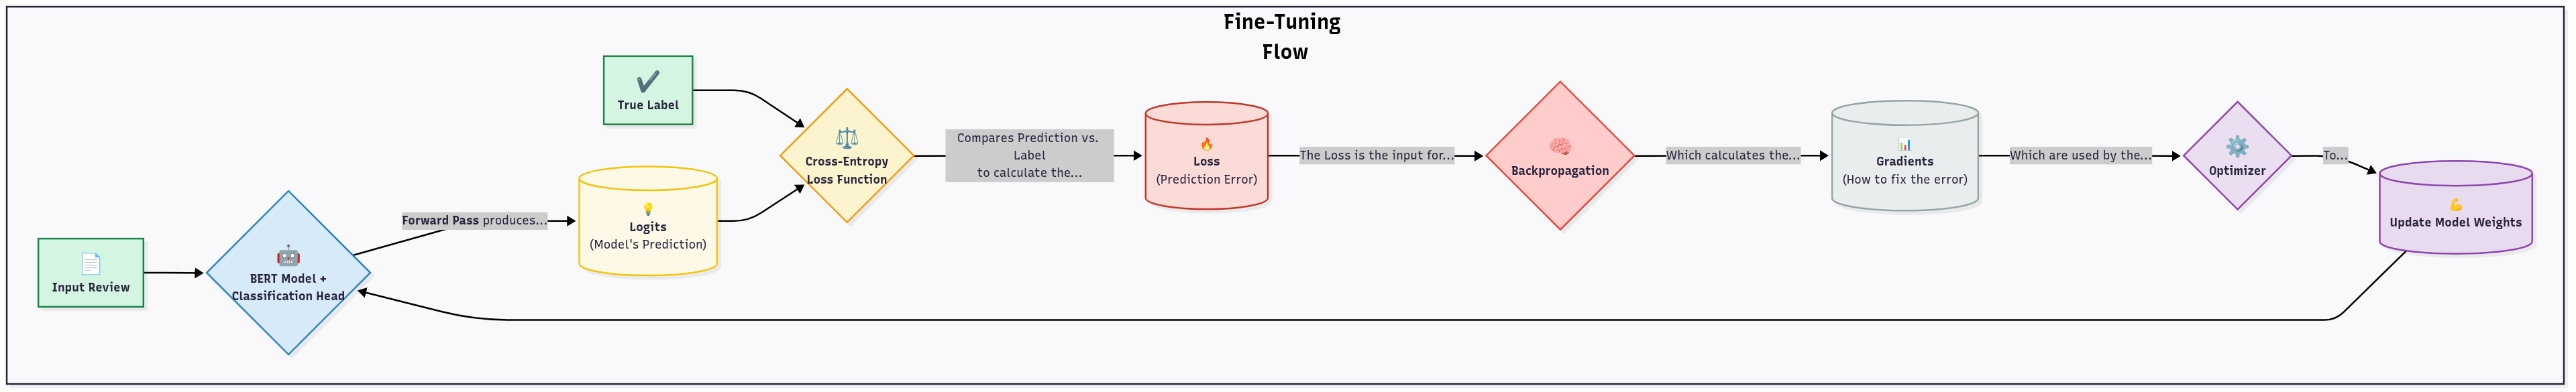

The model was then trained using a standard fine-tuning loop. We fed the **preprocessed data to the model in batches** and iterated over the entire dataset for a set number of epochs. For each batch, we performed a **forward pass to obtain the logits,** which were then compared against the true labels using the CrossEntropyLoss function to calculate the prediction error.

Crucially, we then used **backpropagation to calculate gradients** for all the parameters in the entire model—not just the new classification head, but the **original BERT layers as well.**

Finally, an optimizer **used these gradients to update the model's weights,** progressively adjusting them to **minimize the classification error** and specialize the model for understanding sentiment within movie reviews.

In [10]:
# Modify BertPretrainingModel for classification
class BertClassificationModel(nn.Module):
    def __init__(self, bert_model, num_classes=2):
        super().__init__()
        self.bert = bert_model
        self.config = bert_model.config
        self.classification_head = nn.Linear(bert_model.config.hidden_size, num_classes)            # New layer for classification to fine-tune the model

    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = outputs.pooler_output                                                       # Pooled output is the representation of [CLS] token

        # Classification head
        logits = self.classification_head(pooled_output)
        return logits

# Training loop for fine-tuning
def fine_tune_bert(model, train_dataloader, optimizer, num_epochs):
    model.train();
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        total_loss = 0
        # For each batch in the training dataloader, compute the loss and update the model
        for batch in train_dataloader:
            input_ids = batch['input_ids']                                                          # Input IDs
            attention_mask = batch['attention_mask']                                                # Attention mask
            labels = batch['labels']                                                                # Labels

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask)

            # Compute loss
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            # Update total loss
            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

To adapt BERT for a specific natural language task, this project focuses on fine-tuning it for sentiment analysis of movie reviews. We selected the IMDb dataset, a benchmark for this task. To manage computational resources and allow for rapid experimentation, **we proceeded with a randomly selected 5% sample of the full dataset.**

A comprehensive preprocessing pipeline was applied to clean the data, which involved removing null and duplicate entries, stripping HTML line breaks, and standardizing whitespaces. The final step was to binarize the sentiment labels into a machine-readable format: '1' for positive and '0' for negative.

In [11]:
# Download the dataset and read it into a DataFrame
path = kh.dataset_download("mahmoudshaheen1134/imdp-data");
full_path = os.path.join(path, os.listdir(path)[0])
data = pd.read_csv(full_path)

# Take the first N rows of the dataset (for computational savings)
total_reviews = data.shape[0] * 0.05                                                                # Select 5% of the dataset
data = data.head(int(total_reviews))

# Preprocess the text data
data = data.dropna()                                                                                # Eliminate missing values
data = data.drop_duplicates()                                                                       # Eliminate duplicate reviews
data['review'] = data['review'].apply(lambda x: re.sub(r"<br\s*/?>", "", x))                        # Remove HTML line breaks
data['review'] = data['review'].apply(lambda x: re.sub(r"\s+", " ", x))                             # Normalize whitespace
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)                  # Binarize sentiment labels

# Split the data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['review'], data['sentiment'], test_size=0.2, random_state=42
)

# Create datasets and dataloaders
train_dataset = TextClassificationDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)   # Tokenizing the text and converting the train data into PyTorch tensors
test_dataset = TextClassificationDataset(test_texts.tolist(), test_labels.tolist(), tokenizer)      # Tokenizing the text and converting the test data into PyTorch tensors
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)                            # Creating DataLoader for training set
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)                             # Creating DataLoader for test set

In [12]:
# Create an instance of your pre-training model structure.
model_with_heads = BertPretrainingModel(base_model)

# Load the pre-trained model, adapted weights into this structure.
model_with_heads.load_state_dict(torch.load('pretrained_bert_model.pth'))

# Initialize the fine-tuning model
model = BertClassificationModel(model_with_heads.bert, num_classes=2)

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Fine-tune the model
fine_tune_bert(model, train_dataloader, optimizer, num_epochs=10)

# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_bert_model.pth')

Epoch 1/10, Average Loss: 0.7042
Epoch 2/10, Average Loss: 0.6907
Epoch 3/10, Average Loss: 0.6753
Epoch 4/10, Average Loss: 0.6508
Epoch 5/10, Average Loss: 0.6249
Epoch 6/10, Average Loss: 0.5931
Epoch 7/10, Average Loss: 0.5475
Epoch 8/10, Average Loss: 0.4932
Epoch 9/10, Average Loss: 0.4485
Epoch 10/10, Average Loss: 0.4051


In [13]:
# Evaluate the model on the test dataset
evaluation_metrics = evaluate_model(model, test_dataloader)

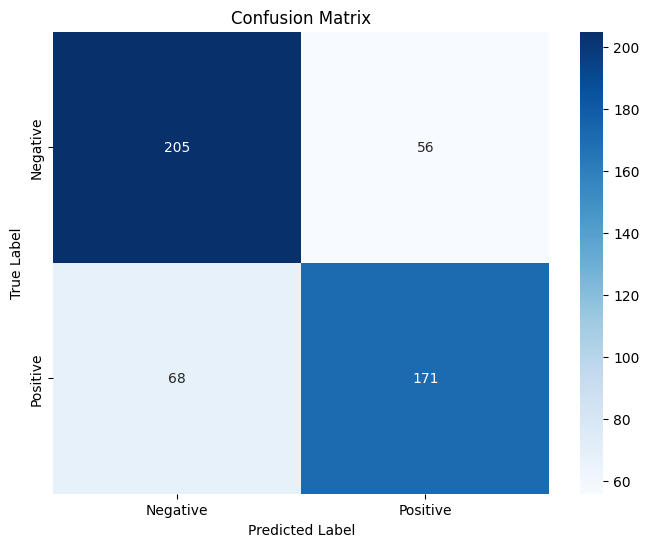

---Evaluation Results:---
Accuracy: 0.7520
Precision: 0.7533
Recall: 0.7155
F1 Score: 0.7339


In [14]:
true_labels = evaluation_metrics['true_labels']
predictions = evaluation_metrics['predictions']

plot_confusion_matrix(true_labels, predictions)

print(f"---Evaluation Results:---")
print(f"Accuracy: {evaluation_metrics['accuracy']:.4f}")
print(f"Precision: {evaluation_metrics['precision']:.4f}")
print(f"Recall: {evaluation_metrics['recall']:.4f}")
print(f"F1 Score: {evaluation_metrics['f1_score']:.4f}")